# EDH Filter Demo

This notebook demonstrates the **Exact Daum-Huang (EDH) Filter** using the class-based implementation from `edh.py`.

## Algorithm 1: Original Exact Flow Daum-Huang Filter

```
Initialization:
  1  Draw {x_0^i}_{i=1}^N from the prior p(x_0)
  2  Set x̂_0 and m_0 as the mean; P_0 as the covariance matrix

  3  for k = 1 to T do
  4    Propagate particles x_{k-1}^i = f_k(x_{k-1}^i) + v_k
  5    Calculate the mean value x̄_k
  6    Apply UKF/EKF prediction:
         (m_{k-1|k-1}, P_{k-1|k-1}) → (m_{k|k-1}, P_{k|k-1})
  7    for j = 1, ..., N_λ do
  8      Set λ = j∆λ
  9      Calculate H_x by linearizing γ_k() at x̄_k
 10      Calculate A and b from (8) and (9) using
           P_{k|k-1}, x̄ and H_x
 11      for i = 1, ..., N do
 12        Evaluate dx_k^i/dλ for each particle from (7)
 13        Migrate particles: x_k^i = x_k^i + ∆λ · dx_k^i/dλ
 14      endfor
 15      Re-evaluate x̄_k using the updated particles x_k^i
 16    endfor
 17    Apply UKF/EKF update:
         (m_{k|k-1}, P_{k|k-1}) → (m_{k|k}, P_{k|k})
 18    Estimate x̂_k from the particles x_k^i using P_{k|k}
 19    Optional: redraw particles x_k^i ~ N(x̂_k, P_{k|k})
 20  endfor
```

## References

- **Ding & Coates (2012)**: "Implementation of the Daum-Huang Exact-Flow Particle Filter", IEEE SSP
- **MATLAB Code**: `PFPF/particle_flow/DH_ExactFlow_Filter.m`

## 1. Setup and Imports

In [1]:
# --- standard libs ---
import sys
from pathlib import Path

# --- third-party libs ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- project root (for Jupyter) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# --- project imports ---
from edh import EDHFilter
from ekf_ukf_pf.ekf import ExtendedKalmanFilter
from acoustic_function import (
    initialize_acoustic_model,
    simulate_trajectory,
    state_transition,
    observation_model,
    compute_observation_jacobian
)

# --- reproducibility ---
tf.random.set_seed(42)
np.random.seed(42)

# --- environment info (optional) ---
print(f"TensorFlow {tf.__version__}")
print(f"GPU available: {bool(tf.config.list_physical_devices('GPU'))}")

TensorFlow 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

# Get filter functions for EKF
state_transition_fn = state_transition # x_t = A * x_{t-1}
observation_fn = observation_model #  z_t = h(x_t) 
A = model_params["Phi"]
state_transition_jacobian_fn = lambda x: A # A
observation_jacobian_fn = compute_observation_jacobian

state_transition_fn = lambda x: state_transition(
    x, model_params, use_real_noise=False, no_noise=True
)

observation_fn = lambda x: observation_model(
    x, model_params, no_noise=True
)

state_transition_jacobian_fn = lambda x, u=None: model_params["Phi"]

observation_jacobian_fn = lambda x: compute_observation_jacobian(
    x, model_params
)

# Create EKF instance
ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model_params['Q'],
    R=model_params['R'],
    x0=model_params['x0_initial_target_states'],
    Sigma0=model_params['P0'] ,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn,
    use_joseph_form=True
)

## 3. Generate Ground Truth Data

In [3]:
# Generate ground truth trajectory and measurements
T = 30  # Number of time steps
tf.random.set_seed(42)
print(f"Generating ground truth trajectory ({T} time steps)...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Measurements shape: {measurements.shape}")

Generating ground truth trajectory (30 time steps)...
Ground truth shape: (16, 31)
Measurements shape: (25, 30)


## 4. Create and Run EDH Filter

### Option 1: Global Linearization (Algorithm 1)

In [4]:
# Create EDH filter with global linearization
edh_filter = EDHFilter(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    n_particle=500,      # Number of particles
    n_lambda=29,         # Number of lambda steps
    lambda_ratio=1.2,    # Exponential spacing ratio
    use_local=False,     # Global linearization (Algorithm 1)
    use_ekf=False,       # Use particle-based covariance
    verbose=True         # Print progress
)

# Run filter on measurements
edh_estimates, edh_particles, edh_covariances = edh_filter.run(
    measurements=measurements,
    model_params=model_params
)


Running EDH Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (Algorithm 1)
  EKF Covariance: Disabled (particle-based)
  Time steps: 30

Processing time steps...
  Step 10/30
  Step 20/30
  Step 30/30

EDH filter completed successfully!
  Estimates shape: (16, 30)
  Particles shape: (16, 500, 30)
  Covariances shape: (16, 16, 30)


### Option 2: With EKF Covariance Tracking - Uncomment to try

In [5]:
# Create EDH filter with EKF covariance tracking
edh_filter_ekf = EDHFilter(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_local=False,
    use_ekf=True,
    ekf_filter=ekf,  # Pass the EKF filter
    verbose=True
)

# Run filter
edh_estimates_ekf, edh_particles_ekf, edh_covariances_ekf = edh_filter_ekf.run(
    measurements=measurements,
    model_params=model_params
)


Running EDH Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (Algorithm 1)
  EKF Covariance: Enabled
  Time steps: 30
  Using provided EKF filter for covariance tracking

Processing time steps...
  Step 10/30
  Step 20/30
  Step 30/30

EDH filter completed successfully!
  Estimates shape: (16, 30)
  Particles shape: (16, 500, 30)
  Covariances shape: (16, 16, 30)


### Option 3: Local Linearization (Algorithm 2) - Uncomment to try

In [6]:
# # Create EDH filter with local linearization
# edh_filter_local = EDHFilter(
    # observation_jacobian=compute_observation_jacobian,
    # observation_model=observation_model,
#     n_particle=500,
#     n_lambda=29,
#     lambda_ratio=1.2,
#     use_local=True,      # Local linearization (Algorithm 2)
#     use_ekf=True,
#     ekf_filter=ekf,  # Pass the EKF filter
#     verbose=True
# )

# # Run filter
# edh_estimates_local, edh_particles_local, edh_covariances_local = edh_filter_local.run(
#     measurements=measurements,
#     model_params=model_params
# )

## 5. Compute Errors

In [7]:
def compute_position_error(estimates, ground_truth, n_targets):
    """Compute position error for each target."""
    errors = []
    
    for i in range(n_targets):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    
    errors = tf.stack(errors, axis=0)  # (n_targets, T)
    mean_error = tf.reduce_mean(errors, axis=0)  # (T,)
    
    return errors, mean_error

# Compute errors
edh_errors, edh_mean_error = compute_position_error(
    edh_estimates, ground_truth[:,1:], model_params['n_targets']
)

# Overall RMSE
rmse = tf.sqrt(tf.reduce_mean((edh_estimates - ground_truth[:,1:])**2))

print("="*60)
print("EDH Filter Performance")
print("="*60)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {edh_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(edh_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(edh_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")
print("="*60)

EDH Filter Performance
Overall RMSE: 0.4069 m
Mean position error (final): 0.6156 m
Mean position error (average): 0.4990 m

Per-target average errors:
  Target 1: 0.5343 m
  Target 2: 0.4275 m
  Target 3: 0.5378 m
  Target 4: 0.4964 m


## 6. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_80398/232542684.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


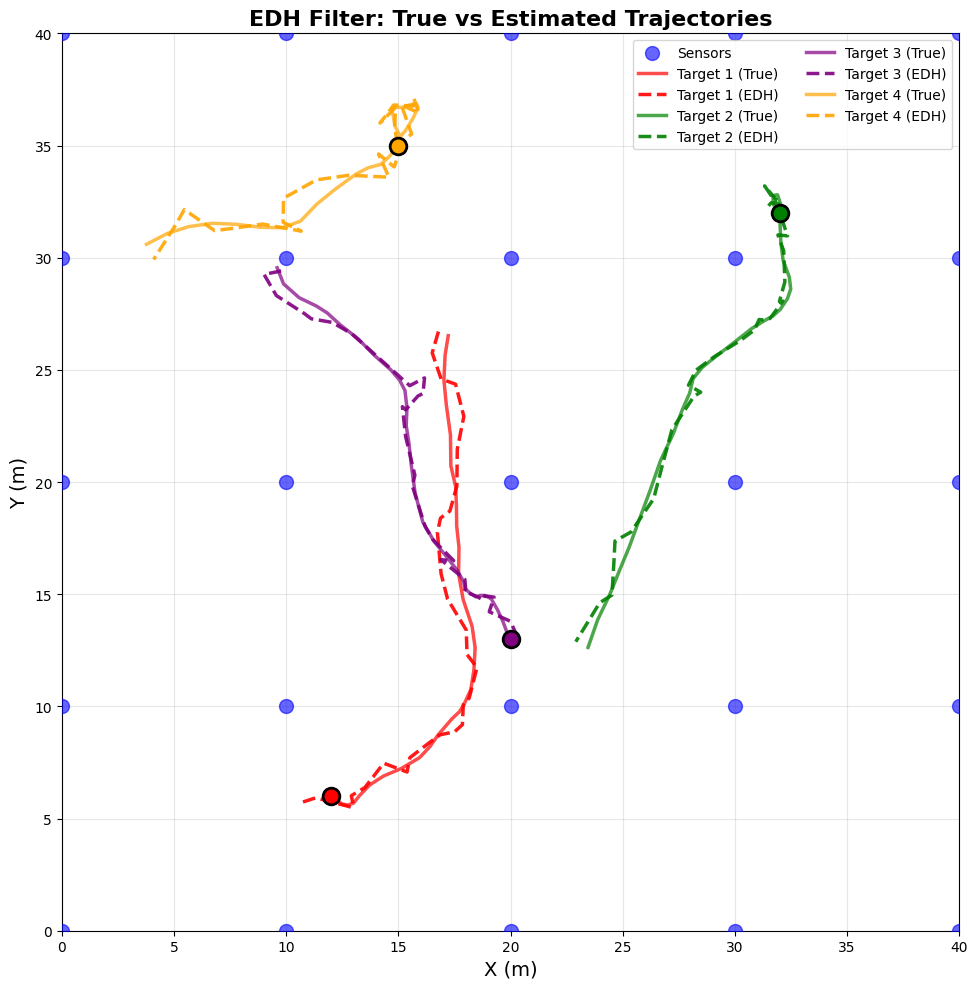

In [8]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(12, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = edh_estimates_ekf.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('EDH Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 7. Plot Error Evolution

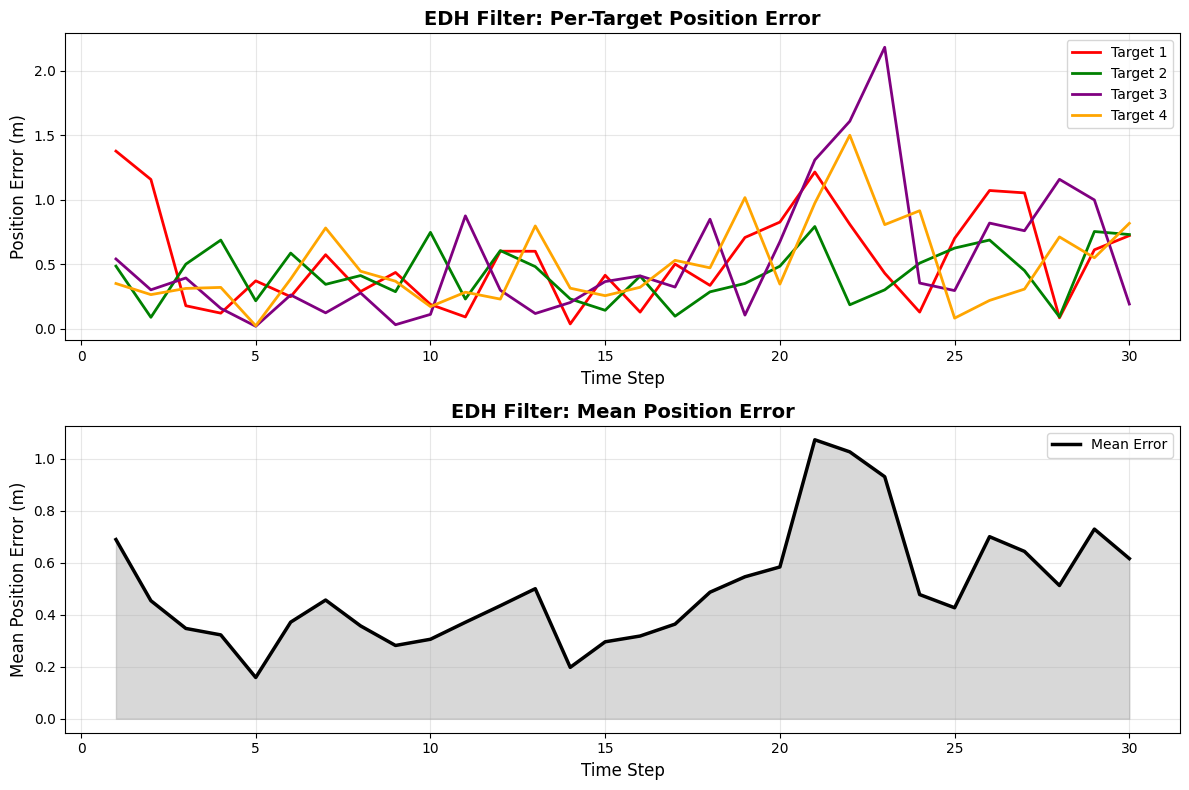

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot per-target errors
colors = ['red', 'green', 'purple', 'orange']
time_steps = np.arange(1, T + 1)

for i in range(model_params['n_targets']):
    ax1.plot(time_steps, edh_errors[i].numpy(), 
            color=colors[i], linewidth=2, label=f'Target {i+1}')

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Position Error (m)', fontsize=12)
ax1.set_title('EDH Filter: Per-Target Position Error', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot mean error
ax2.plot(time_steps, edh_mean_error.numpy(), 
        color='black', linewidth=2.5, label='Mean Error')
ax2.fill_between(time_steps, 0, edh_mean_error.numpy(), 
                 color='gray', alpha=0.3)

ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Mean Position Error (m)', fontsize=12)
ax2.set_title('EDH Filter: Mean Position Error', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

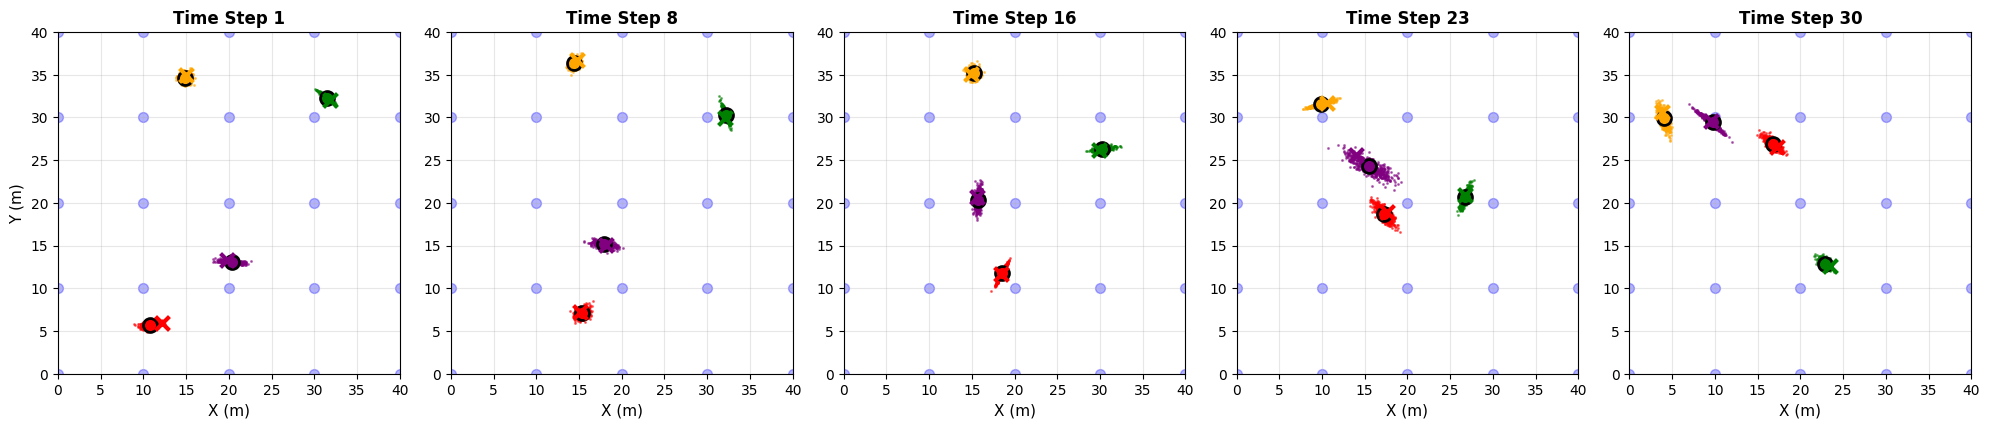

In [10]:
# Plot particles at specific time steps
time_indices = [0, T//4, T//2, 3*T//4, T-1]  # Start, 25%, 50%, 75%, End
fig, axes = plt.subplots(1, len(time_indices), figsize=(20, 4))

colors = ['red', 'green', 'purple', 'orange']

for idx, t in enumerate(time_indices):
    ax = axes[idx]
    
    # Plot sensors
    sensors = model_params['sensor_positions'].numpy()
    ax.scatter(sensors[:, 0], sensors[:, 1], 
              c='blue', marker='o', s=50, alpha=0.3, zorder=1)
    
    # Plot particles for each target
    particles_t = edh_particles[:, :, t].numpy()
    
    for i in range(model_params['n_targets']):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        # Particles
        ax.scatter(particles_t[x_idx, :], particles_t[y_idx, :],
                  c=colors[i], marker='.', s=5, alpha=0.5, zorder=2)
        
        # True position
        ax.scatter(gt[x_idx, t+1], gt[y_idx, t+1],
                  c=colors[i], marker='x', s=100, linewidths=3,
                  label=f'Target {i+1} (True)', zorder=4)
        
        # Estimate
        ax.scatter(est[x_idx, t], est[y_idx, t],
                  c=colors[i], marker='o', s=100, 
                  edgecolors='black', linewidths=2, zorder=3)
    
    ax.set_xlim([0, model_params['sim_area_size']])
    ax.set_ylim([0, model_params['sim_area_size']])
    ax.set_aspect('equal')
    ax.set_title(f'Time Step {t+1}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.set_ylabel('Y (m)', fontsize=11)
    ax.set_xlabel('X (m)', fontsize=11)

plt.tight_layout()
plt.show()

## 9. Summary

### Key Features of the EDHFilter Class:

1. **Clean Object-Oriented Interface**:
   - `EDHFilter(...)` - Create filter instance with configuration
   - `filter.initialize(model_params)` - Initialize particles and covariance
   - `filter.step(measurement, model_params)` - Process single measurement
   - `filter.run(measurements, model_params)` - Process entire sequence

2. **Flexible Configuration**:
   - `n_particle`: Number of particles
   - `n_lambda`: Number of lambda integration steps
   - `lambda_ratio`: Exponential spacing ratio
   - `use_local`: Switch between global/local linearization
   - `use_ekf`: Use EKF or particle-based covariance
   - `verbose`: Control output verbosity

3. **Algorithm Implementation**:
   - Follows Algorithm 1 from Ding & Coates (2012)
   - Matches MATLAB reference implementation
   - Each method corresponds to specific algorithm lines

4. **Easy to Extend**:
   - Add new observation models
   - Implement different motion models
   - Customize particle initialization
   - Add resampling or regularization